In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # calculate distance matrix
from scipy.linalg import lu # calculate LU decomposition
from scipy.optimize import minimize # minimization of scalar function
from itertools import combinations

# 1. Generate $Y$

## 1-1. Distance matrix

 $ d_{ij} = ||X_i - X_j||$

In [27]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):
  x_coords = np.random.normal(xmu, xsd, size=N_points)
  y_coords = np.random.normal(ymu, ysd, size=N_points)
  coords = np.column_stack((x_coords, y_coords))

  return coords

In [28]:
# function that calculates distances between coordinates
def distances(coords):
  distances = cdist(coords, coords, metric='Euclidean')

  return distances

In [29]:
np.random.seed(24)

In [30]:
# set parameters
p = 1000 # dimensionaltiy

In [31]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)

In [32]:
# get distance matrix
d = distances(X)
d.shape

(1000, 1000)

## 1-2. Covariance Matrix $\Sigma$
$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) $

In [33]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [34]:
# set parameter for Sigma
paramTrue = [1, 1/2]
SigmaTrue = Sigma(paramTrue, d)

## 1-3. Generate data $Y$
* $ Y = \Sigma^{1/2} \cdot V $
  * $\Sigma$ is positive semi definite
  * $V \sim N(0, I_p)$

* Dataframe of $Y$ ; N $\times$ p
  * Size: N = 1000
  * Dimensionality: p = 1000







In [35]:
# get sigmahalf
## cf. check if SigmaTrue is positive definite
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue)
    print('Covariance matrix is positive definite')
else:
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [36]:
import pandas as pd

In [37]:
N = 1000 # size

results = []

for i in range(N):
  V = np.random.normal(0, 1, p).reshape(p, 1)
  results.append(np.dot(SigmaHalf, V))

col_names = ['y{}'.format(i+1) for i in range(p)]
y_df = pd.DataFrame(np.reshape(results, (N, p)), columns=col_names)

# 2. Calculated Covariance


In [38]:
cov = np.cov(y_df.T) # cf. np.cov; each row represents variavble, each column a single observation
cov.shape

(1000, 1000)

In [39]:
# make matrix into array
d_plot = d.reshape((p*p,)) 
cov_plot = cov.reshape((p*p, ))

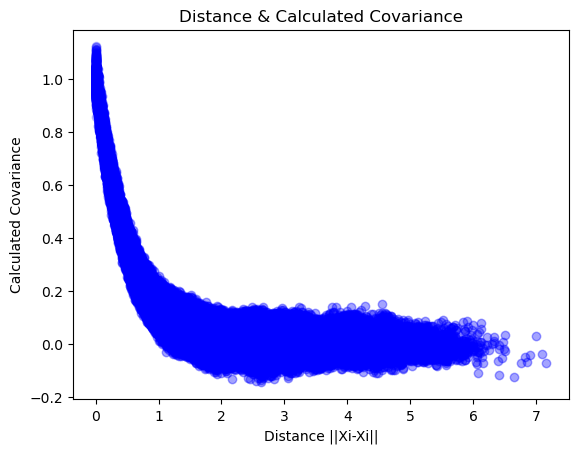

In [40]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.show()

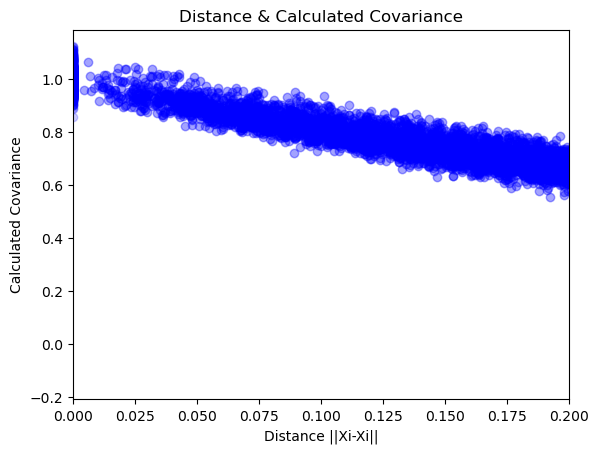

In [41]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.xlim(0, 0.2)
plt.show()

## 2*. Remove i = j pairs

In [42]:
# remove if distance = 0
cal_cov_df = pd.DataFrame({'Distance': d_plot, 'Calculated Covariance': cov_plot})
mask = (cal_cov_df['Distance'] != 0)

filtered_df = cal_cov_df[mask]

d_plot = filtered_df['Distance']
cov_plot = filtered_df['Calculated Covariance']


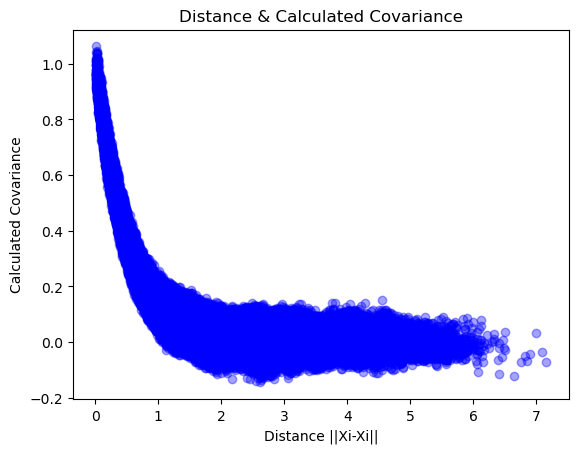

In [43]:
# plotting
plt.scatter(d_plot, cov_plot, c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distance ||Xi-Xi||')
plt.title('Distance & Calculated Covariance')
plt.show()

In [44]:
import pickle

In [45]:
# with open('distance.pickle', 'wb') as file:
#     pickle.dump(d_plot, file)

# with open('calculated_covariance.pickle', 'wb') as file:
#     pickle.dump(cov_plot, file)

In [46]:
# read the memory list & time stamps file
with open('distance.pickle', 'rb') as file:
    d_plot = pickle.load(file)

with open('calculated_covariance.pickle', 'rb') as file:
    cov_plot = pickle.load(file)

# 3. Regression
* Regression methods tryout:
    * OLS Regrssion
    * Nonlinear Least Squares Regression
    * Gaussian Process Regression (Kriging)
    * Bayesian Inference
    * Kernel Ridge Regression

## 3-1. OLS Regression
* Perform OLS regression by transforming the covariance model into a linear form.
    * $ ln(\Sigma(\boldsymbol{\theta})) = ln(\theta_1) -\frac{1}{\theta_2} (||x_i - x_j||) $
* After obtaining the estimates $ln(\theta_1), \theta_2 $, back-transfrom to obtain $\theta_1, \theta_2$

In [47]:
def ols(X, y):
    """
    Perform Ordinary Least Squares (OLS) for linear regression.
    
    Parameters:
        X (numpy.array): Input features (independent variables) with shape (n_samples, n_features).
        y (numpy.array): Target values (dependent variable) with shape (n_samples,).
        
    Returns:
        numpy.array: Coefficients of the linear regression model.
    """
    # Add a column of ones to the input features for the intercept term
    X_with_intercept = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Calculate the OLS coefficients using the formula: (X^T X)^(-1) X^T y
    coefficients = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    
    return coefficients

In [48]:
dis = np.array(d_plot)[:, np.newaxis]
ln_cov = np.log(1) - 2 * d_plot # true param = 1, 1/2

In [49]:
log_theta1, inv_theta2 = ols(dis, ln_cov)[0], ols(dis, ln_cov)[1]
# back-transform
ols_theta1 = np.exp(log_theta1)
ols_theta2 = -1/inv_theta2

In [50]:
x_fit0 = np.linspace(min(d_plot), max(d_plot), 100)
y_fit0 = ols_theta1 * np.exp((-1/ols_theta2) * x_fit0)
fit0 = 'Fitted curve: {} * exp(-{} * X)'.format(round(ols_theta1,4), round(1/ols_theta2,4))

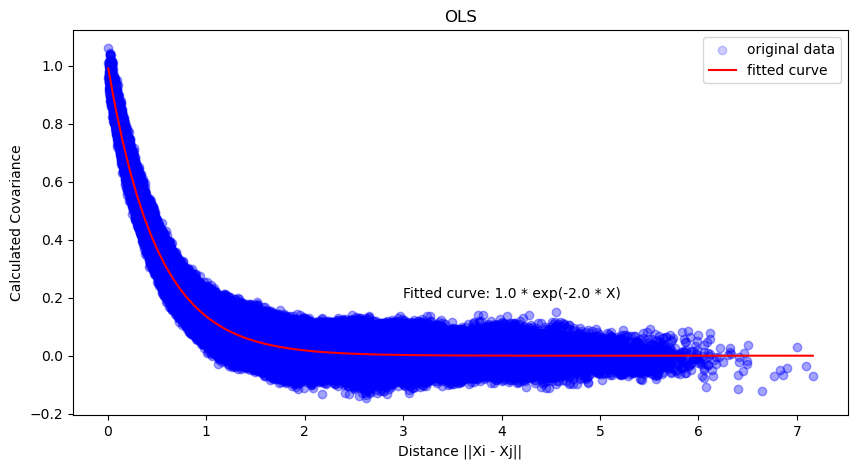

In [57]:
# exponential regression
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Scatter plot of the original data
ax.scatter(d_plot, cov_plot, c='blue', alpha=0.2, label='original data')

# Plot the fitted curve
ax.plot(x_fit0, y_fit0, c='red', label='fitted curve')

ax.set_ylabel('Calculated Covariance')
ax.set_xlabel('Distance ||Xi - Xj||')
ax.set_title('OLS')
ax.legend()
ax.text(3.0, 0.2, fit0)
# ax.set_xlim(0, 0.2)

plt.show()

## 3-2. Nonlinear Least Squares Regression
* Exponential Regression

In [52]:
from scipy.optimize import curve_fit

In [53]:
# define the exponential function
def exp_func(dis, theta1, theta2):
    return theta1*np.exp(-theta2*dis)

In [54]:
# perform exponential regression
params, param_cov = curve_fit(exp_func, d_plot, cov_plot)

cov_theta1, cov_theta2 = params

# generate fitted curve
x_fit1 = np.linspace(min(d_plot), max(d_plot), 100)
y_fit1 = exp_func(x_fit1, cov_theta1, cov_theta2)

fit1 = 'Fitted curve: {} * exp(-{} * X)'.format(round(cov_theta1,4), round(cov_theta2,4))

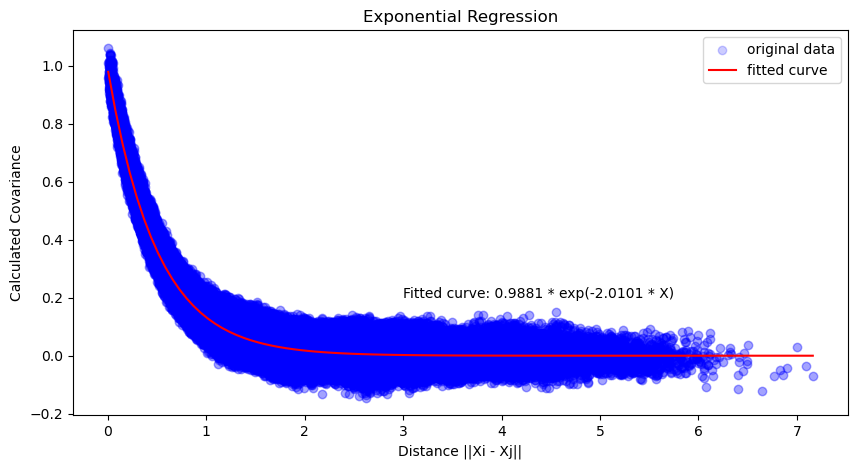

In [56]:
# exponential regression
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Scatter plot of the original data
ax.scatter(d_plot, cov_plot, c='blue', alpha=0.2, label='original data')

# Plot the fitted curve
ax.plot(x_fit1, y_fit1, c='red', label='fitted curve')

ax.set_ylabel('Calculated Covariance')
ax.set_xlabel('Distance ||Xi - Xj||')
ax.set_title('Exponential Regression')
ax.legend()
ax.text(3.0, 0.2, fit1)
# ax.set_xlim(0, 0.2)

plt.show()